<header align="center">
  <h1>* T-MAJ *</h1>
  <h1>~ Voltron ~</h1>
  <p>
    <i>Alexandre.D | Alexandre.P | Bastien.F</i>
  </p>
  <img src="https://images.unsplash.com/photo-1499346030926-9a72daac6c63?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1170&q=80" alt="air img"/>
  <h2>Daily climate time series analysis</h2>
</header>

# Setup

## Imports

In [669]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

import helpers

In [670]:
import importlib
importlib.reload(helpers)

<module 'helpers' from '/home/nowaffle/epitech/voltron/src/ai/helpers.py'>

## Constants

In [671]:
TRAIN_SIZE = 0.8
VAL_SIZE = 0.1
TEST_SIZE = 0.1
EPOCHS = 100
BATCH_SIZE = 128
SEED = 5

## Load data

In [672]:
# Parse dates and set date column to index
train_df = pd.read_csv("./data/DailyDelhiClimateTrain.csv",
                       parse_dates=["date"],
                       index_col=["date"])
test_df = pd.read_csv("./data/DailyDelhiClimateTest.csv",
                      parse_dates=["date"],
                      index_col=["date"])
print(f"Initial train size: {train_df.shape[0]}")
print(f"Initial test size: {test_df.shape[0]}")
print(f"Initial ratio: {(test_df.shape[0] / train_df.shape[0]):.2f}")

Initial train size: 1462
Initial test size: 114
Initial ratio: 0.08


In [673]:
df = pd.concat([train_df, test_df])
train_df = df.iloc[:int((1 - TEST_SIZE) * df.shape[0])]
test_df = df.iloc[int((1 - TEST_SIZE) * df.shape[0]):]
print(f"Updated train size: {train_df.shape[0]}")
print(f"Updated test size: {test_df.shape[0]}")
print(f"Updated ratio: {(test_df.shape[0] / train_df.shape[0]):.2f}")

Updated train size: 1418
Updated test size: 158
Updated ratio: 0.11


# EDA

## Plot values

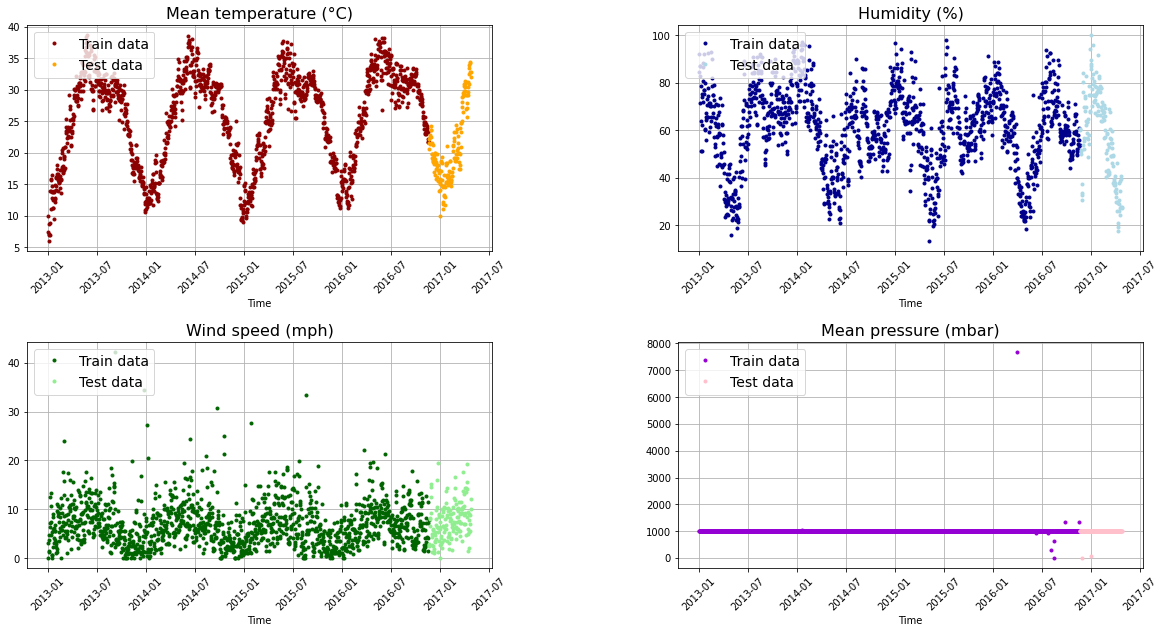

In [674]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,
                                             2,
                                             figsize=(20, 10),
                                             gridspec_kw={
                                                 'wspace': .4,
                                                 'hspace': .4
                                             })

helpers.plot_time_series(ax1,
                         train_df.index,
                         train_df["meantemp"],
                         "Mean temperature (°C)",
                         label='Train data',
                         c='darkred')
helpers.plot_time_series(ax1,
                         test_df.index,
                         test_df["meantemp"],
                         "Mean temperature (°C)",
                         label='Test data',
                         c='orange')
helpers.plot_time_series(ax2,
                         train_df.index,
                         train_df["humidity"],
                         "Humidity (%)",
                         label='Train data',
                         c='darkblue')
helpers.plot_time_series(ax2,
                         test_df.index,
                         test_df["humidity"],
                         "Humidity (%)",
                         label='Test data',
                         c='lightblue')
helpers.plot_time_series(ax3,
                         train_df.index,
                         train_df["wind_speed"],
                         "Wind speed (mph)",
                         label='Train data',
                         c='darkgreen')
helpers.plot_time_series(ax3,
                         test_df.index,
                         test_df["wind_speed"],
                         "Wind speed (mph)",
                         label='Test data',
                         c='lightgreen')
helpers.plot_time_series(ax4,
                         train_df.index,
                         train_df["meanpressure"],
                         "Mean pressure (mbar)",
                         label='Train data',
                         c='darkviolet')
helpers.plot_time_series(ax4,
                         test_df.index,
                         test_df["meanpressure"],
                         "Mean pressure (mbar)",
                         label='Test data',
                         c='pink')

# fig.savefig('./graphs/train_plus_test_data.png', facecolor='white')

## Remove outliers

In [675]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1576.000000,1576.000000,1576.000000,1576.000000
mean,25.221918,60.445229,6.899262,1010.593178
std,7.345014,16.979994,4.510725,175.242704
min,6.000000,13.428571,0.000000,-3.041667
25%,18.500000,49.750000,3.700000,1001.875000
50%,27.166667,62.440476,6.363571,1009.055556
75%,31.142857,72.125000,9.262500,1015.200000
max,38.714286,100.000000,42.220000,7679.333333


In [676]:
clf = IsolationForest(contamination=6e-3, random_state=SEED)
clf.fit(df['meanpressure'].to_numpy().reshape(-1,1))
outliers = clf.predict(df['meanpressure'].to_numpy().reshape(-1,1)) == -1

In [677]:
df['meanpressure'].replace(to_replace=df['meanpressure'][outliers].to_numpy(),
                           value=df['meanpressure'].mean(),
                           inplace=True)


In [678]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1576.000000,1576.000000,1576.000000,1576.000000
mean,25.221918,60.445229,6.899262,1008.579832
std,7.345014,16.979994,4.510725,7.381090
min,6.000000,13.428571,0.000000,991.375000
25%,18.500000,49.750000,3.700000,1002.000000
50%,27.166667,62.440476,6.363571,1009.171429
75%,31.142857,72.125000,9.262500,1015.145604
max,38.714286,100.000000,42.220000,1023.000000


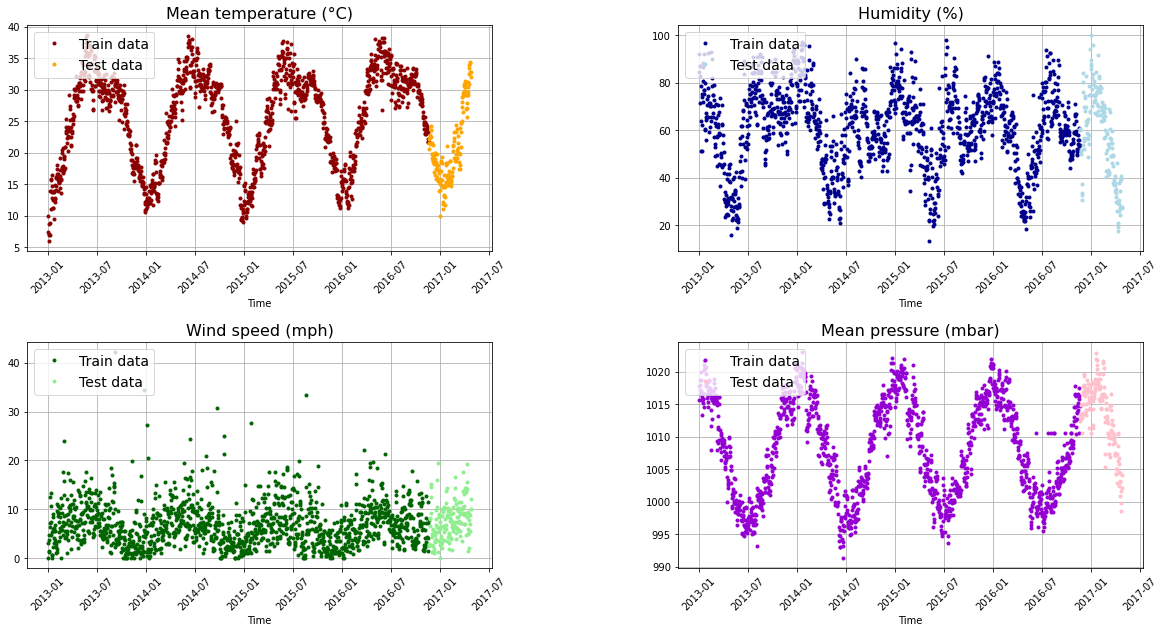

In [679]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,
                                             2,
                                             figsize=(20, 10),
                                             gridspec_kw={
                                                 'wspace': .4,
                                                 'hspace': .4
                                             })

helpers.plot_time_series(ax1,
                         train_df.index,
                         train_df["meantemp"],
                         "Mean temperature (°C)",
                         label='Train data',
                         c='darkred')
helpers.plot_time_series(ax1,
                         test_df.index,
                         test_df["meantemp"],
                         "Mean temperature (°C)",
                         label='Test data',
                         c='orange')
helpers.plot_time_series(ax2,
                         train_df.index,
                         train_df["humidity"],
                         "Humidity (%)",
                         label='Train data',
                         c='darkblue')
helpers.plot_time_series(ax2,
                         test_df.index,
                         test_df["humidity"],
                         "Humidity (%)",
                         label='Test data',
                         c='lightblue')
helpers.plot_time_series(ax3,
                         train_df.index,
                         train_df["wind_speed"],
                         "Wind speed (mph)",
                         label='Train data',
                         c='darkgreen')
helpers.plot_time_series(ax3,
                         test_df.index,
                         test_df["wind_speed"],
                         "Wind speed (mph)",
                         label='Test data',
                         c='lightgreen')
helpers.plot_time_series(ax4,
                         train_df.index,
                         train_df["meanpressure"],
                         "Mean pressure (mbar)",
                         label='Train data',
                         c='darkviolet')
helpers.plot_time_series(ax4,
                         test_df.index,
                         test_df["meanpressure"],
                         "Mean pressure (mbar)",
                         label='Test data',
                         c='pink')

# fig.savefig('./graphs/train_plus_test_data_fixed.png', facecolor='white')

## Correlation matrix

Text(0.5, 1.0, 'Correlation matrix')

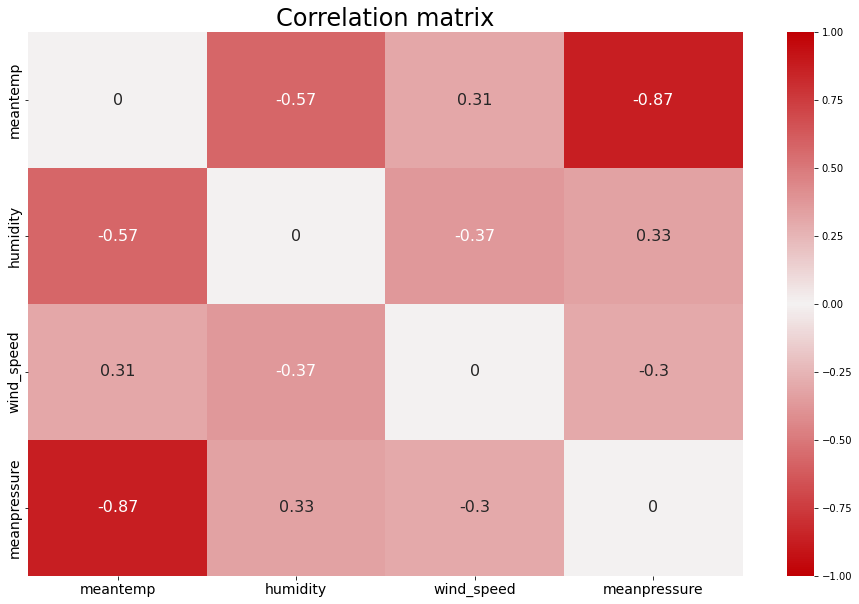

In [680]:
fig, ax = plt.subplots(figsize=(16, 10))
corr_mat = train_df.corr().replace(to_replace=1.0, value=0)
cmap = sns.diverging_palette(12, 12, s=100, l=40, as_cmap=True)
sns.heatmap(ax=ax,
            data=corr_mat,
            annot=True,
            center=0,
            vmin=-1,
            vmax=1,
            cmap=cmap,
            annot_kws={'size': 16})
ax.set_xticklabels(corr_mat.columns, size=14)
ax.set_yticklabels(corr_mat.columns, size=14)
ax.set_title("Correlation matrix", fontsize=24)

# fig.savefig('./graphs/correlation_matrix.png', facecolor='white')

# Preprocessing

## Normalize data

In [681]:
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[df_scaled.columns] = scaler.fit_transform(df[df.columns])
df_scaled.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,-2.073073,1.417103,-1.530010,0.960439
2013-01-02,-2.427167,1.858940,-0.869152,1.249557
2013-01-03,-2.458944,1.564382,-0.502502,1.367012
2013-01-04,-2.254659,0.641435,-1.256500,1.163725
2013-01-05,-2.617833,1.554564,-0.709482,1.073376


## Split data

In [682]:
df_size = len(df_scaled)
train_size = int(df_size * TRAIN_SIZE)
val_size = int(df_size * VAL_SIZE)
train_df = df_scaled[:train_size]
val_df = df_scaled[train_size:train_size + val_size]
test_df = df_scaled[train_size + val_size:]

In [683]:
num_features = df.shape[1]

## Windowing data

In [684]:
WINDOW_SIZE = 7
HORIZON = 1

In [685]:
single_step_window = helpers.WindowGenerator(input_width=WINDOW_SIZE,
                                             label_width=HORIZON,
                                             shift=HORIZON,
                                             train_df=train_df,
                                             val_df=val_df,
                                             test_df=test_df)
wide_window = helpers.WindowGenerator(input_width=30,
                                      label_width=30,
                                      shift=HORIZON,
                                      train_df=train_df,
                                      val_df=val_df,
                                      test_df=test_df)

In [686]:
print(single_step_window)
print('-'*30)
print(wide_window)

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): None
------------------------------
Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): None


# Training

In [687]:
loss = tf.keras.losses.MeanSquaredError()
metrics = [tf.keras.metrics.MeanAbsoluteError()]

## Baseline

In [688]:
baseline = helpers.Baseline()
baseline.compile(loss=loss, metrics=metrics)

In [689]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

5/5 [==============================] - 0s 3ms/step - loss: 0.2532 - mean_absolute_error: 0.3177


In [690]:
baseline.predict(single_step_window.test).shape

5/5 [==============================] - 0s 2ms/step


(152, 1, 4)

5/5 [==============================] - 0s 2ms/step


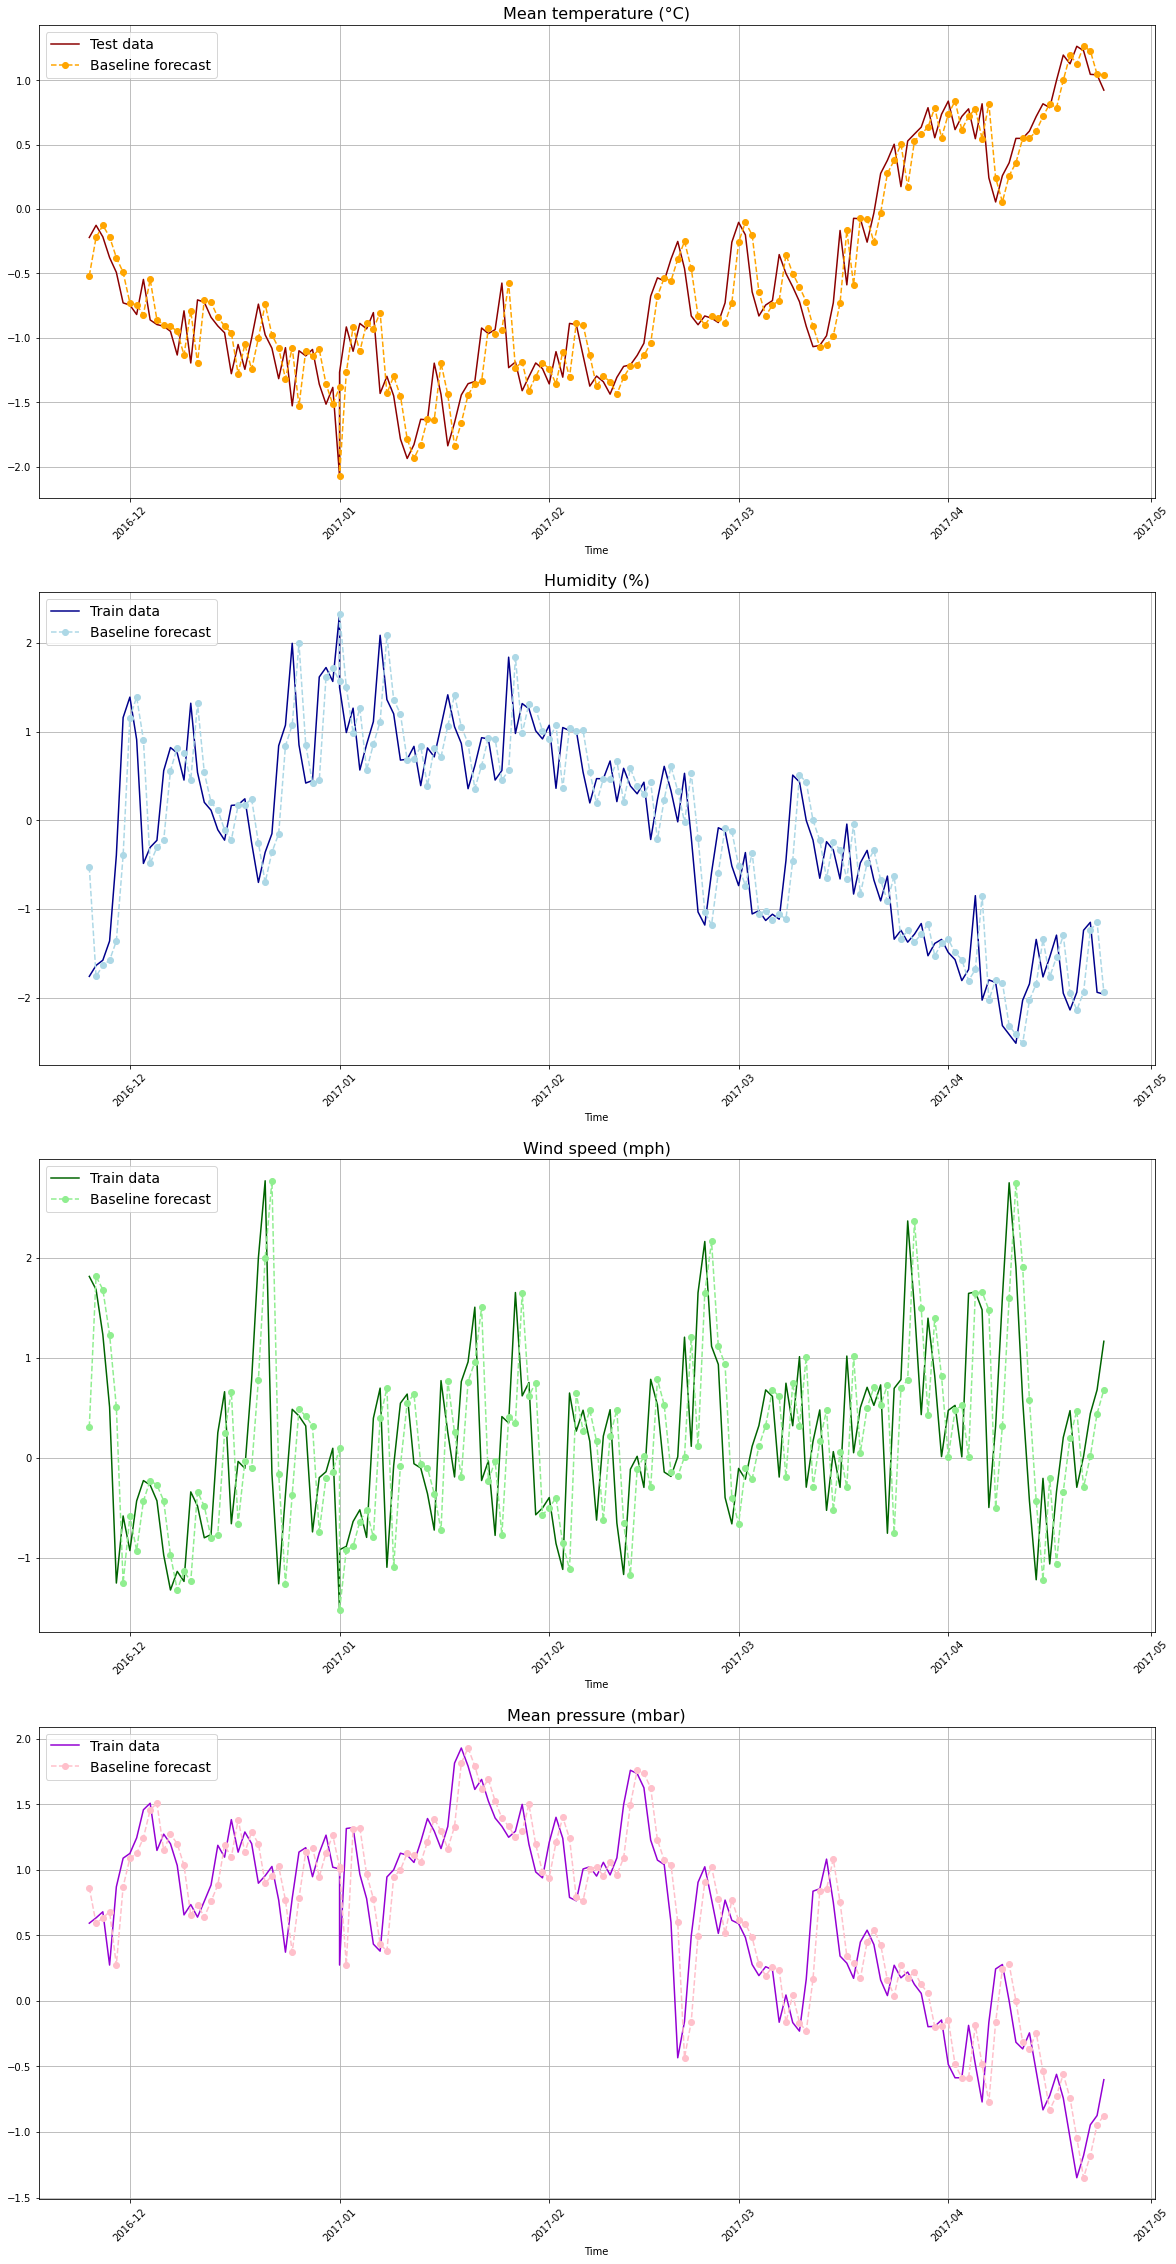

In [691]:
single_step_window.plot_ts(baseline, "Baseline forecast")

## Dense

In [692]:
dense = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -WINDOW_SIZE:, :]),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.GlobalAvgPool1D(keepdims=True),
    tf.keras.layers.Dense(units=num_features),
])

In [693]:
history = helpers.compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/100
40/40 [==============================] - 1s 11ms/step - loss: 0.6302 - mean_absolute_error: 0.6050 - val_loss: 0.3111 - val_mean_absolute_error: 0.4189
Epoch 2/100
40/40 [==============================] - 0s 9ms/step - loss: 0.3779 - mean_absolute_error: 0.4258 - val_loss: 0.2913 - val_mean_absolute_error: 0.4055
Epoch 3/100
40/40 [==============================] - 0s 9ms/step - loss: 0.3619 - mean_absolute_error: 0.4120 - val_loss: 0.2760 - val_mean_absolute_error: 0.3894
Epoch 4/100
40/40 [==============================] - 0s 9ms/step - loss: 0.3567 - mean_absolute_error: 0.4060 - val_loss: 0.2748 - val_mean_absolute_error: 0.3865
Epoch 5/100
40/40 [==============================] - 0s 9ms/step - loss: 0.3552 - mean_absolute_error: 0.4051 - val_loss: 0.2782 - val_mean_absolute_error: 0.3882
Epoch 6/100
40/40 [==============================] - 0s 8ms/step - loss: 0.3522 - mean_absolute_error: 0.4032 - val_loss: 0.2734 - val_mean_absolute_error: 0.3845
Epoch 7/100
40/40 [==

5/5 [==============================] - 0s 4ms/step


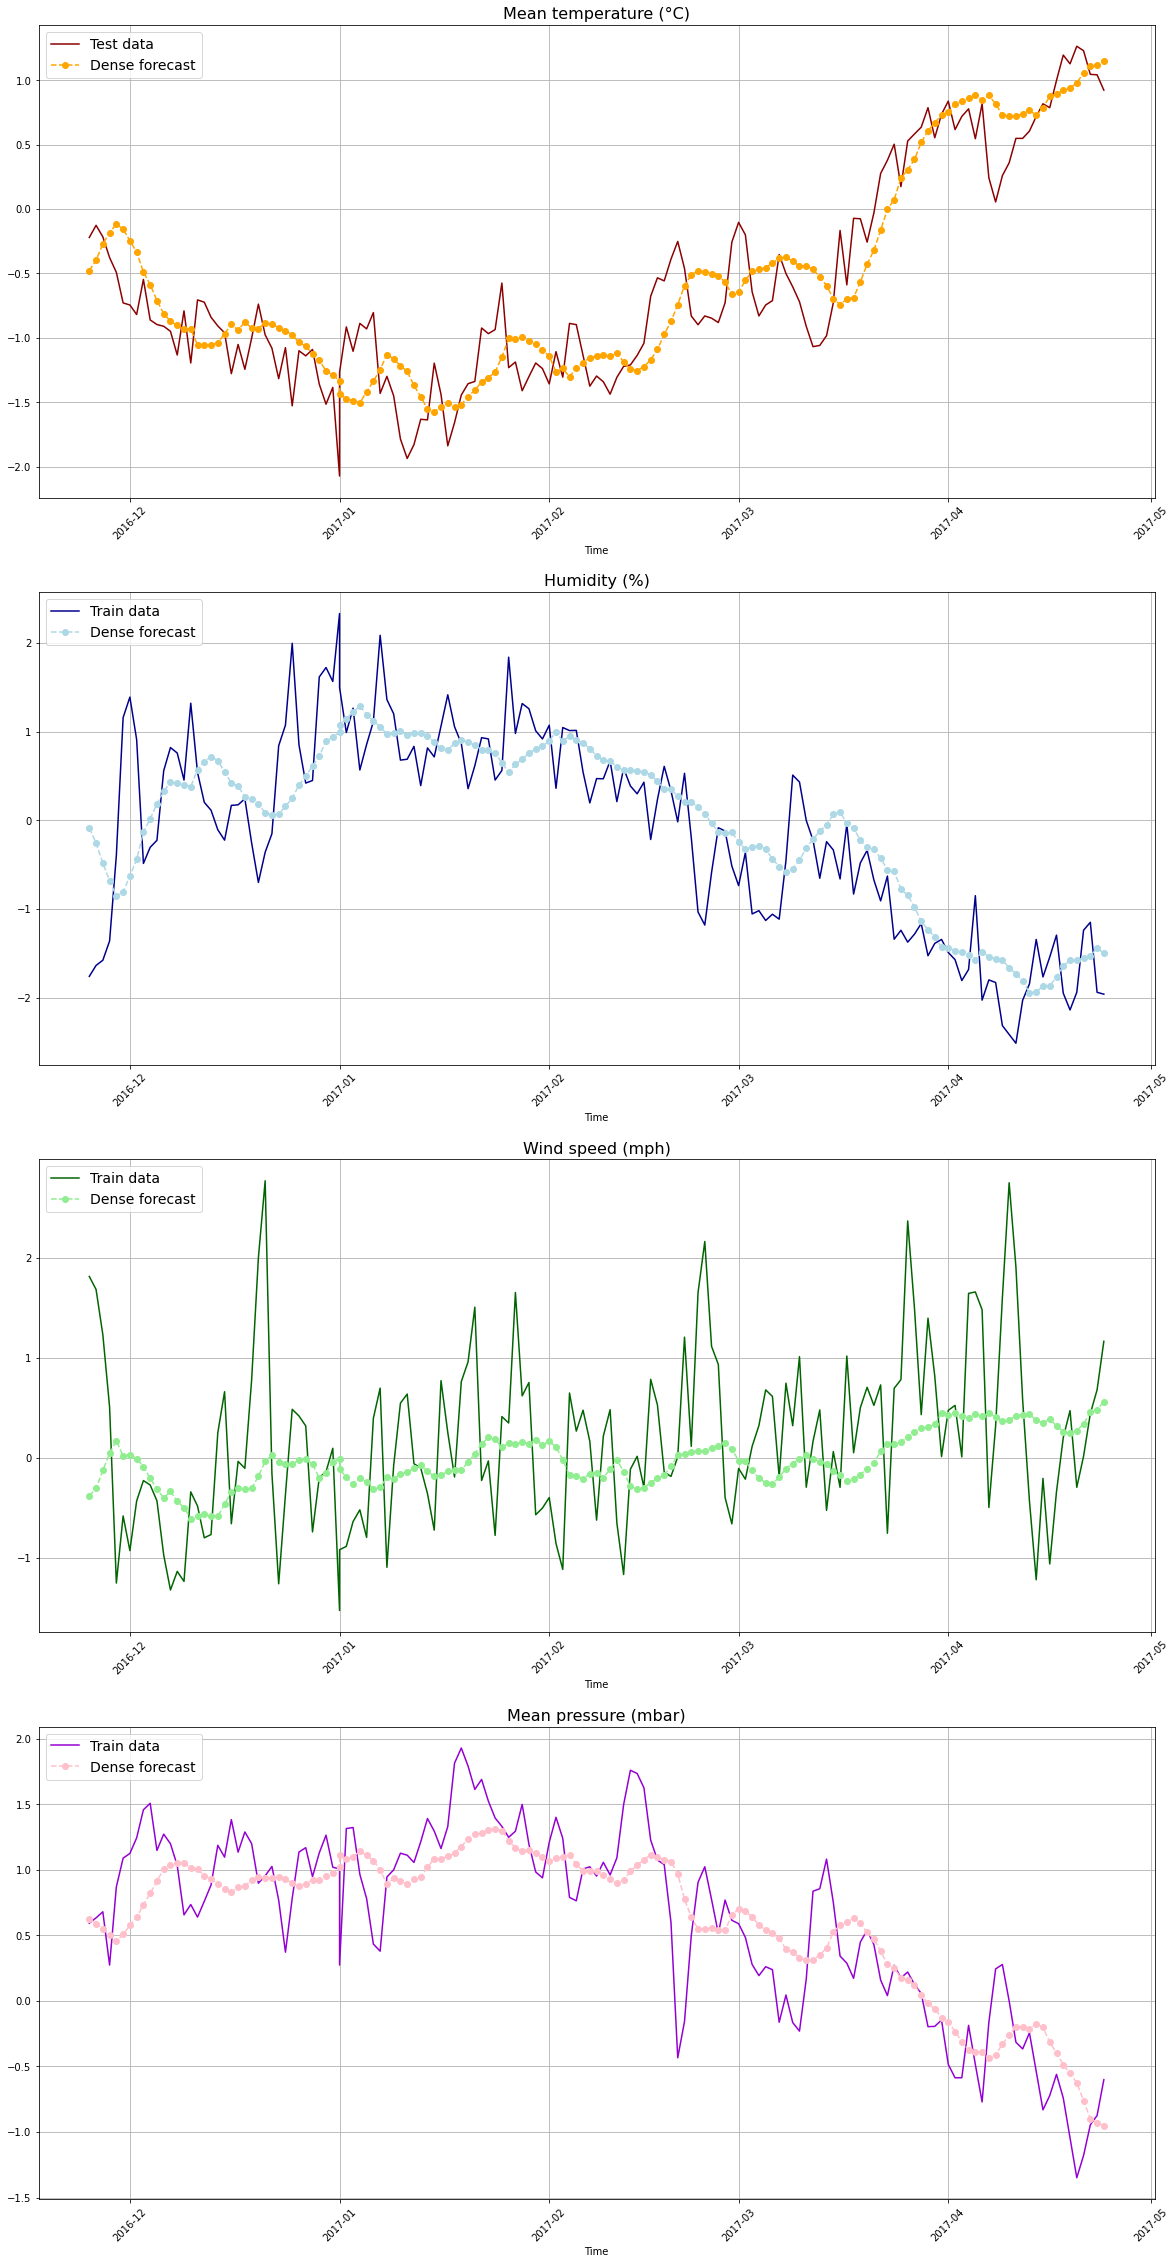

In [694]:
single_step_window.plot_ts(dense, title="Dense forecast")

## LSTM

In [695]:
%%time
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.Dense(units=num_features)
])

history = helpers.compile_and_fit(lstm_model, single_step_window)

val_performance['LSTM'] = lstm_model.evaluate(single_step_window.val)
performance['LSTM'] = lstm_model.evaluate(single_step_window.test, verbose=0)

Epoch 1/100
40/40 [==============================] - 3s 25ms/step - loss: 0.7074 - mean_absolute_error: 0.6585 - val_loss: 0.4000 - val_mean_absolute_error: 0.4948
Epoch 2/100
40/40 [==============================] - 0s 12ms/step - loss: 0.4020 - mean_absolute_error: 0.4504 - val_loss: 0.2966 - val_mean_absolute_error: 0.4075
Epoch 3/100
40/40 [==============================] - 1s 13ms/step - loss: 0.3789 - mean_absolute_error: 0.4285 - val_loss: 0.2873 - val_mean_absolute_error: 0.3988
Epoch 4/100
40/40 [==============================] - 0s 11ms/step - loss: 0.3713 - mean_absolute_error: 0.4208 - val_loss: 0.2805 - val_mean_absolute_error: 0.3914
Epoch 5/100
40/40 [==============================] - 1s 12ms/step - loss: 0.3630 - mean_absolute_error: 0.4144 - val_loss: 0.2678 - val_mean_absolute_error: 0.3790
Epoch 6/100
40/40 [==============================] - 0s 12ms/step - loss: 0.3575 - mean_absolute_error: 0.4081 - val_loss: 0.2602 - val_mean_absolute_error: 0.3694
Epoch 7/100
40/4

5/5 [==============================] - 0s 4ms/step


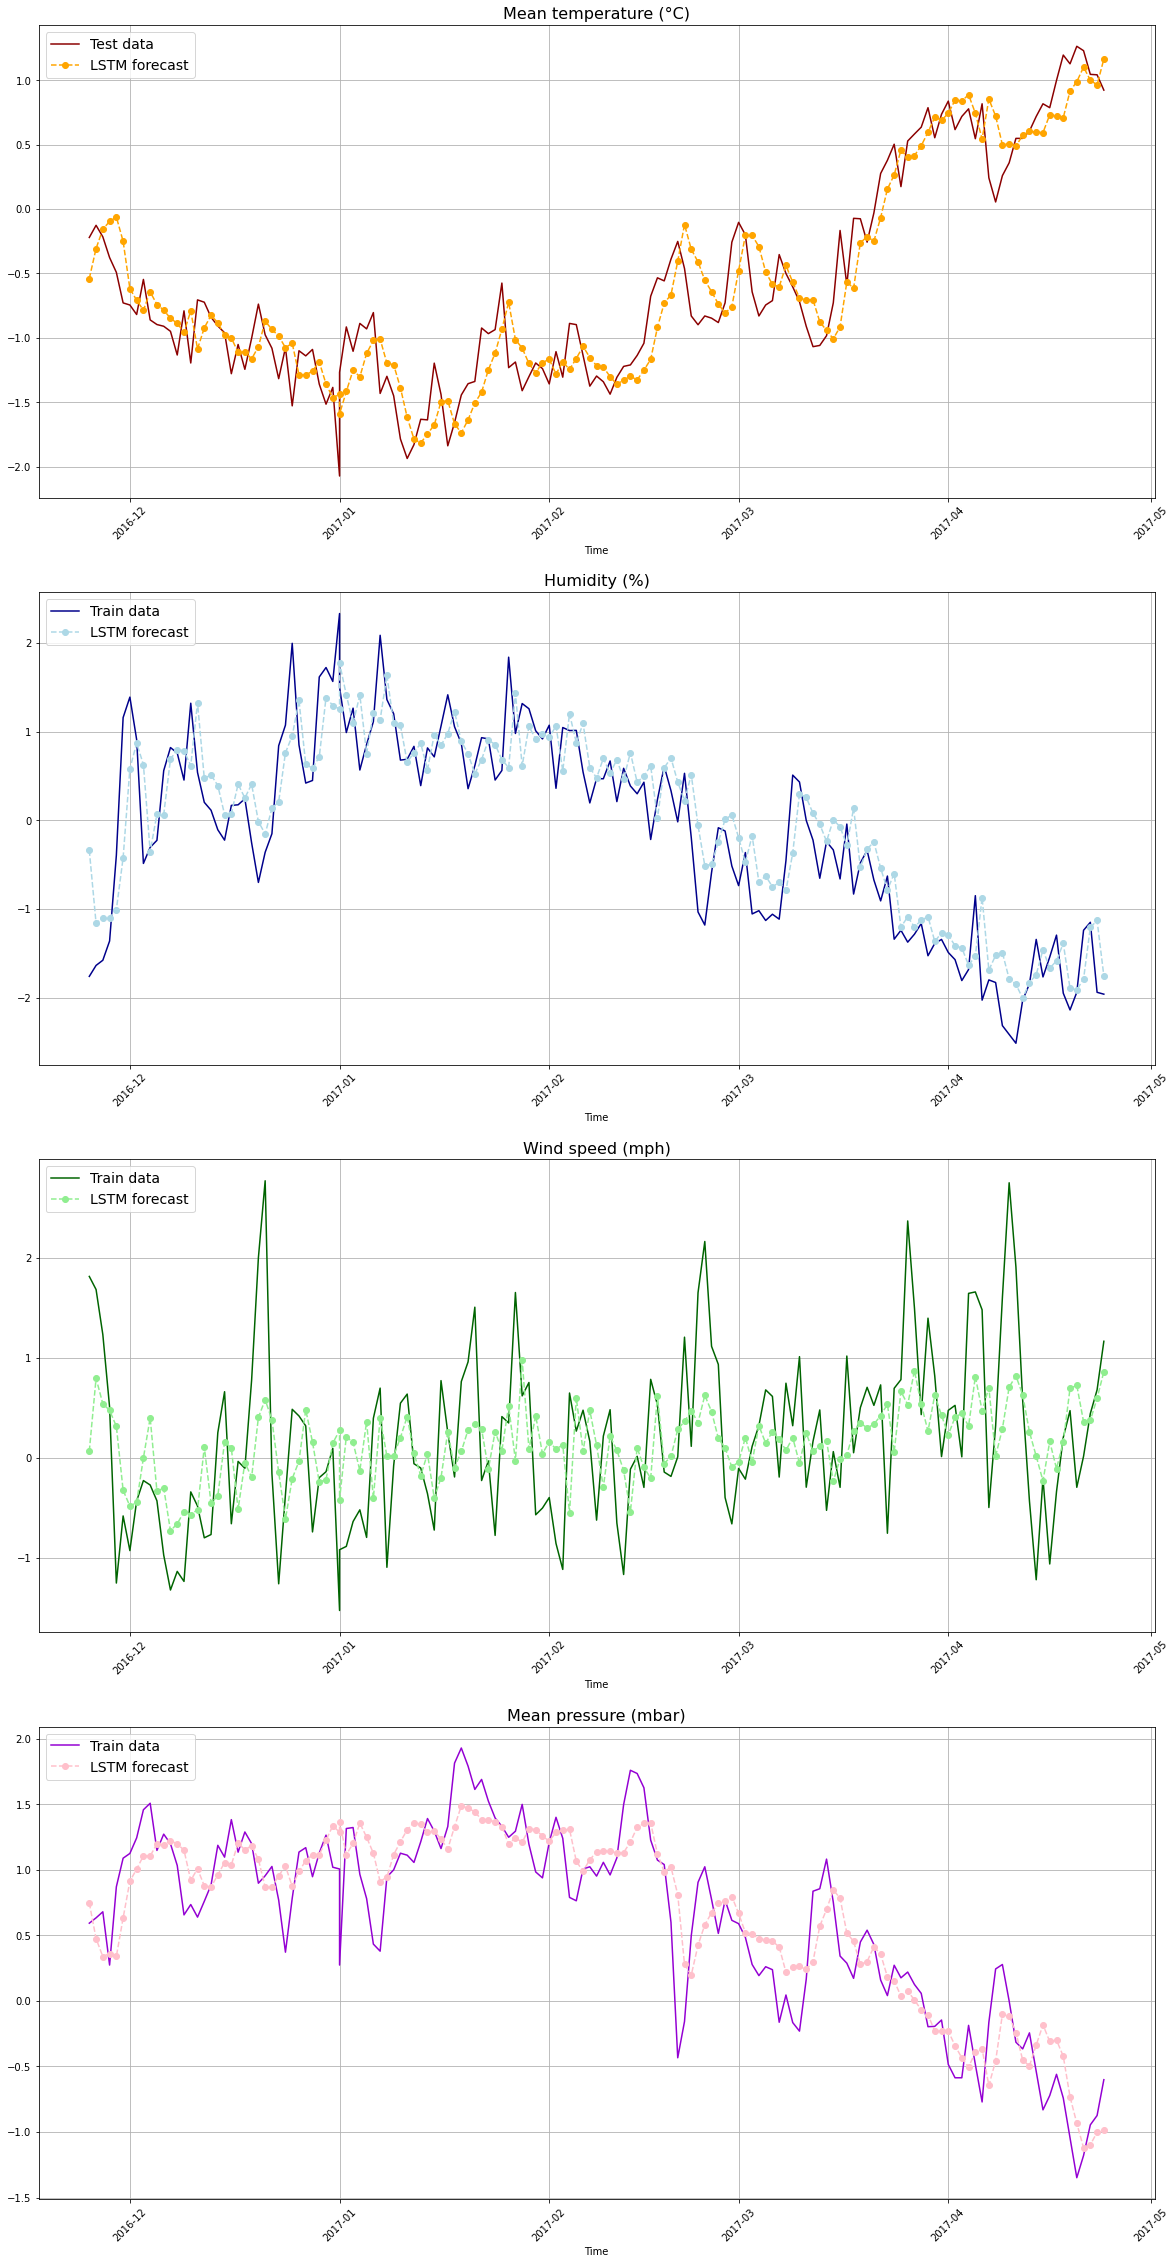

In [696]:
single_step_window.plot_ts(lstm_model, title="LSTM forecast")

## Residual LSTM

In [697]:
%%time
residual_lstm = helpers.CustomResidualWrapper(
    tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = helpers.compile_and_fit(residual_lstm, single_step_window)

val_performance['Residual LSTM'] = residual_lstm.evaluate(single_step_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(single_step_window.test, verbose=0)

Epoch 1/100
40/40 [==============================] - 3s 23ms/step - loss: 0.3956 - mean_absolute_error: 0.3643 - val_loss: 0.2522 - val_mean_absolute_error: 0.3172
Epoch 2/100
40/40 [==============================] - 0s 11ms/step - loss: 0.3938 - mean_absolute_error: 0.3634 - val_loss: 0.2500 - val_mean_absolute_error: 0.3162
Epoch 3/100
40/40 [==============================] - 0s 10ms/step - loss: 0.3884 - mean_absolute_error: 0.3612 - val_loss: 0.2448 - val_mean_absolute_error: 0.3133
Epoch 4/100
40/40 [==============================] - 0s 11ms/step - loss: 0.3735 - mean_absolute_error: 0.3565 - val_loss: 0.2320 - val_mean_absolute_error: 0.3070
Epoch 5/100
40/40 [==============================] - 0s 11ms/step - loss: 0.3377 - mean_absolute_error: 0.3458 - val_loss: 0.2150 - val_mean_absolute_error: 0.3026
Epoch 6/100
40/40 [==============================] - 0s 10ms/step - loss: 0.3096 - mean_absolute_error: 0.3410 - val_loss: 0.2158 - val_mean_absolute_error: 0.3052
Epoch 7/100
40/4

5/5 [==============================] - 0s 3ms/step


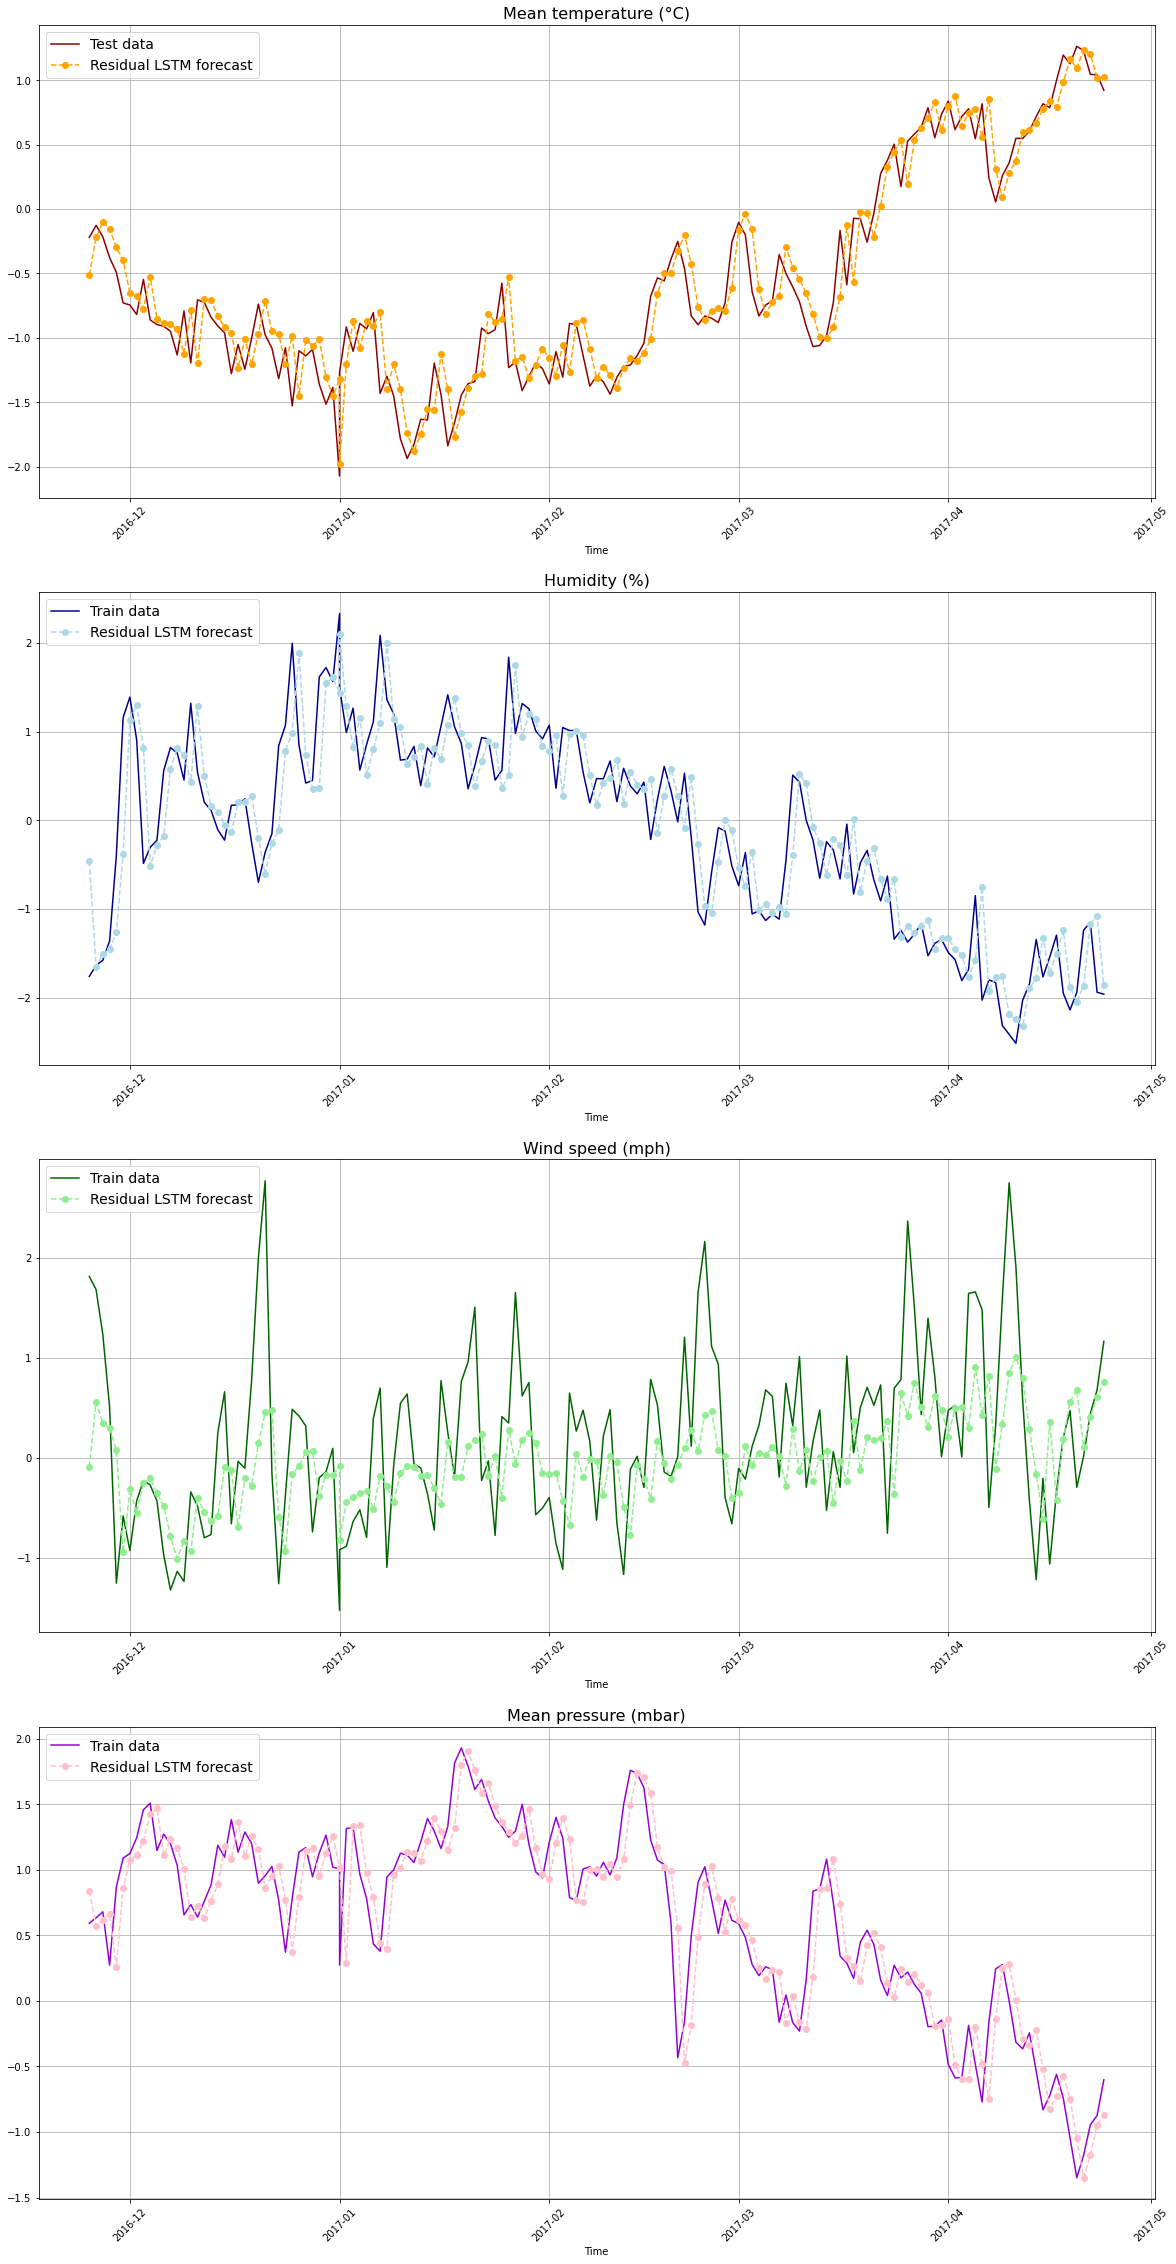

In [698]:
single_step_window.plot_ts(residual_lstm, title="Residual LSTM forecast")

## Conv1D

In [699]:
CONV_WIDTH = 3
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(128,
                           kernel_size=CONV_WIDTH,
                           padding="causal",
                           activation="relu"),
    tf.keras.layers.Conv1D(128,
                           kernel_size=CONV_WIDTH,
                           padding="causal",
                           activation="relu"),
    tf.keras.layers.GlobalAvgPool1D(keepdims=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(num_features)
])

history = helpers.compile_and_fit(conv_model, single_step_window)

val_performance['Conv'] = conv_model.evaluate(single_step_window.val)
performance['Conv'] = conv_model.evaluate(single_step_window.test, verbose=0)

Epoch 1/100
40/40 [==============================] - 1s 12ms/step - loss: 0.5201 - mean_absolute_error: 0.5288 - val_loss: 0.3118 - val_mean_absolute_error: 0.4272
Epoch 2/100
40/40 [==============================] - 0s 9ms/step - loss: 0.3834 - mean_absolute_error: 0.4312 - val_loss: 0.2821 - val_mean_absolute_error: 0.3937
Epoch 3/100
40/40 [==============================] - 0s 10ms/step - loss: 0.3711 - mean_absolute_error: 0.4214 - val_loss: 0.2814 - val_mean_absolute_error: 0.3936
Epoch 4/100
40/40 [==============================] - 0s 10ms/step - loss: 0.3608 - mean_absolute_error: 0.4133 - val_loss: 0.2777 - val_mean_absolute_error: 0.3893
Epoch 5/100
40/40 [==============================] - 0s 9ms/step - loss: 0.3577 - mean_absolute_error: 0.4082 - val_loss: 0.2753 - val_mean_absolute_error: 0.3882
Epoch 6/100
40/40 [==============================] - 0s 10ms/step - loss: 0.3439 - mean_absolute_error: 0.3990 - val_loss: 0.2538 - val_mean_absolute_error: 0.3668
Epoch 7/100
40/40 

5/5 [==============================] - 0s 4ms/step


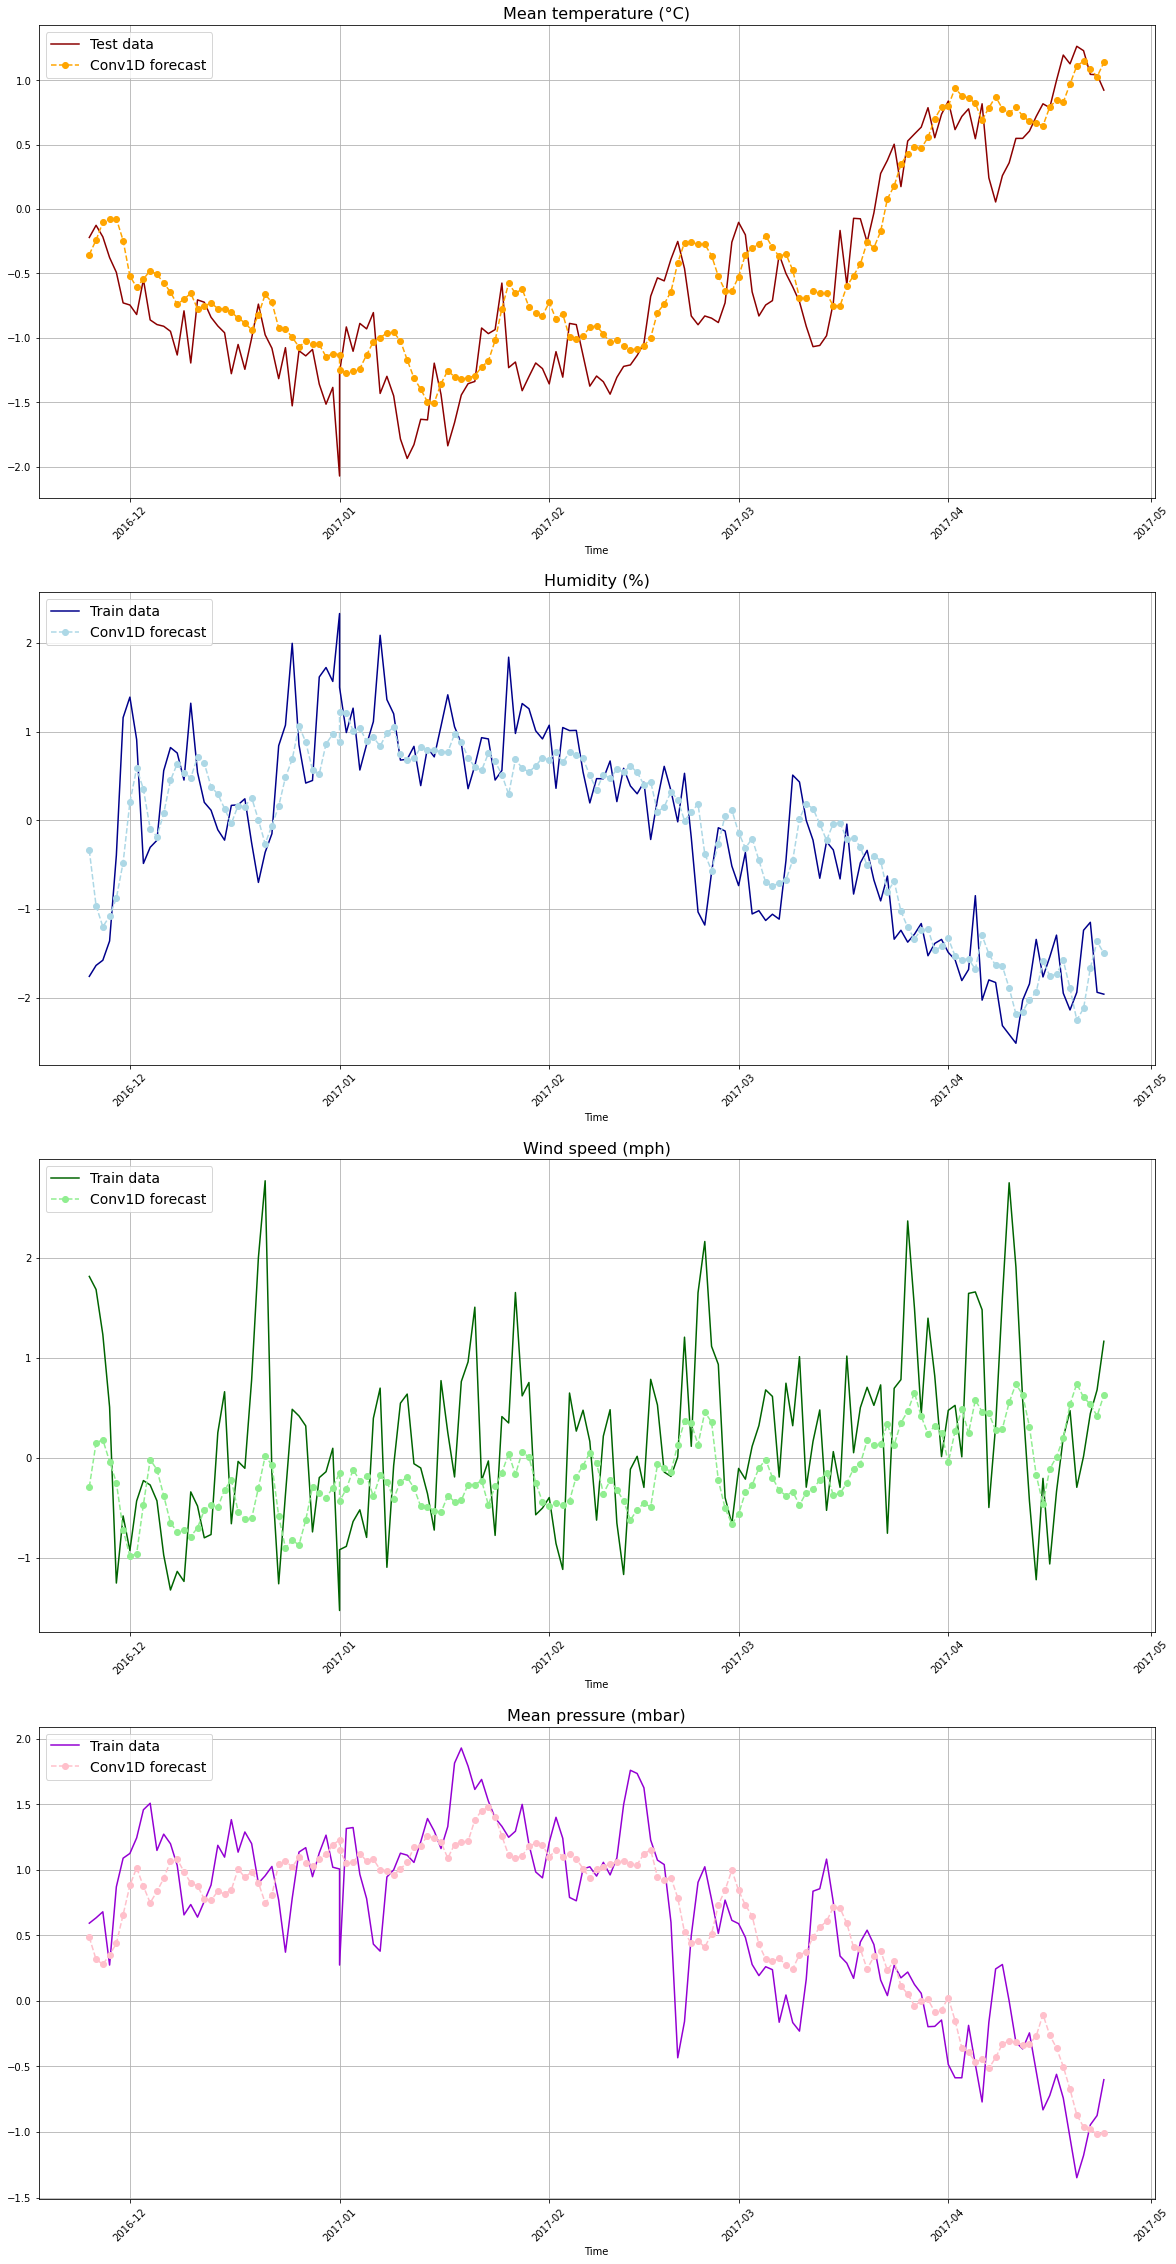

In [700]:
single_step_window.plot_ts(conv_model, title="Conv1D forecast")

# Evaluation

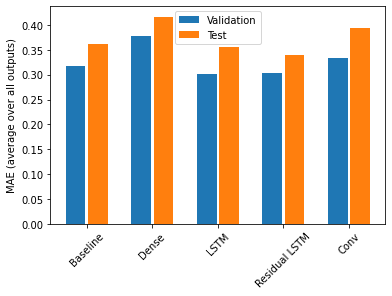

In [701]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index(metric_name)
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [702]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.3616
Dense          : 0.4165
LSTM           : 0.3554
Residual LSTM  : 0.3390
Conv           : 0.3944


# Save best model

In [703]:
residual_lstm.save('model/residual_lstm')

INFO:tensorflow:Assets written to: model/residual_lstm/assets


INFO:tensorflow:Assets written to: model/residual_lstm/assets


In [704]:
reloaded_model = tf.keras.models.load_model('model/residual_lstm')

In [660]:
reloaded_model.evaluate(single_step_window.test)

5/5 [==============================] - 0s 6ms/step - loss: 0.2415 - mean_absolute_error: 0.3413


[0.24154993891716003, 0.34132710099220276]

# Prediction with different windows

## window = 1->30, horizon = 1

In [93]:
%%time
val_perf = []
test_perf = []
for i in range(1,31):
    w = helpers.WindowGenerator(input_width=i,
                                label_width=1,
                                shift=1,
                                train_df=train_df,
                                val_df=val_df,
                                test_df=test_df)
    residual_lstm = helpers.CustomResidualWrapper(
        tf.keras.models.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(
            num_features,
            # The predicted deltas should start small.
            # Therefore, initialize the output layer with zeros.
            kernel_initializer=tf.initializers.zeros())
    ]))

    _ = helpers.compile_and_fit(residual_lstm, w, patience=15)

    val_perf.append(residual_lstm.evaluate(w.val))
    test_perf.append(residual_lstm.evaluate(w.test, verbose=0))

Epoch 1/100
40/40 [==============================] - 3s 28ms/step - loss: 0.3885 - mean_absolute_error: 0.3620 - val_loss: 0.2354 - val_mean_absolute_error: 0.3086
Epoch 2/100
40/40 [==============================] - 1s 15ms/step - loss: 0.3347 - mean_absolute_error: 0.3456 - val_loss: 0.2101 - val_mean_absolute_error: 0.3014
Epoch 3/100
40/40 [==============================] - 1s 15ms/step - loss: 0.2941 - mean_absolute_error: 0.3382 - val_loss: 0.2108 - val_mean_absolute_error: 0.3050
Epoch 4/100
40/40 [==============================] - 1s 15ms/step - loss: 0.2887 - mean_absolute_error: 0.3378 - val_loss: 0.2072 - val_mean_absolute_error: 0.3018
Epoch 5/100
40/40 [==============================] - 1s 15ms/step - loss: 0.2874 - mean_absolute_error: 0.3369 - val_loss: 0.2079 - val_mean_absolute_error: 0.3020
Epoch 6/100
40/40 [==============================] - 1s 15ms/step - loss: 0.2858 - mean_absolute_error: 0.3356 - val_loss: 0.2086 - val_mean_absolute_error: 0.3030
Epoch 7/100
40/4

In [95]:
val_mae = [v[1] for v in val_perf]
test_mae = [v[1] for v in test_perf]

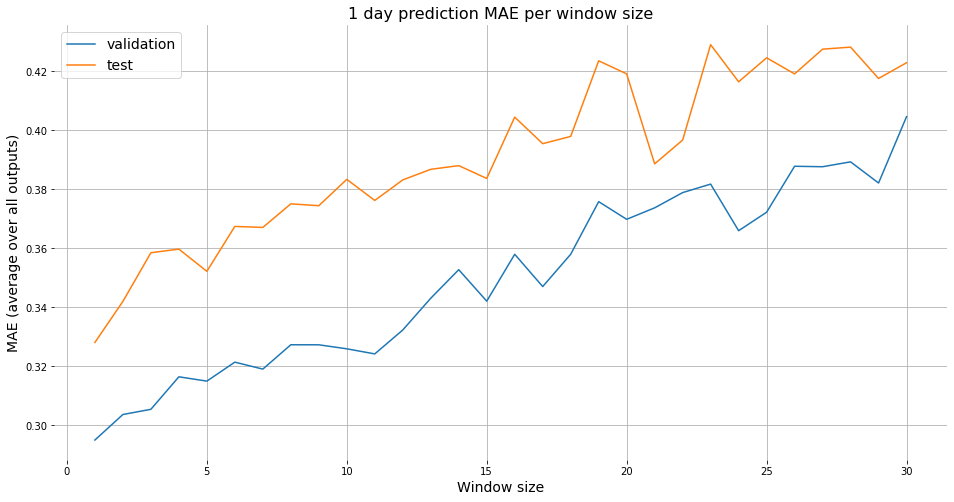

In [129]:
x = np.linspace(1,30,30)
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(x, val_mae, label='validation')
ax.plot(x, test_mae, label='test')
ax.grid(True)
ax.legend(fontsize=14);
ax.set_title('1 day prediction MAE per window size', fontsize=16)
ax.set_frame_on(False)
ax.set_xlabel('Window size', fontsize=14)
ax.set_ylabel('MAE (average over all outputs)', fontsize=14)

# fig.savefig('graphs/window_size_benchmark.png', facecolor='white')

## window = 1->30, horizon = 7

Total window size: 14
Input indices: [0 1 2 3 4 5 6]
Label indices: [ 7  8  9 10 11 12 13]
Label column name(s): None

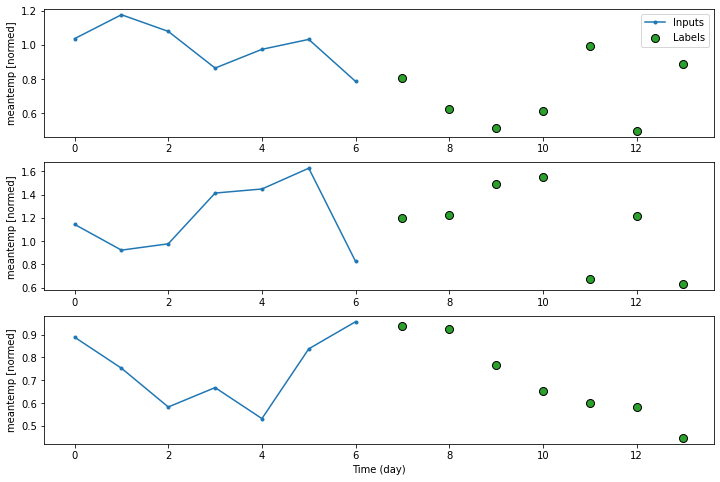

In [132]:
HORIZON = 7
multi_window = helpers.WindowGenerator(input_width=7,
                                       label_width=HORIZON,
                                       shift=HORIZON,
                                       train_df=train_df,
                                       val_df=val_df,
                                       test_df=test_df)

multi_window.plot()
multi_window

Epoch 1/100
40/40 [==============================] - 3s 24ms/step - loss: 0.8717 - mean_absolute_error: 0.7583 - val_loss: 0.4577 - val_mean_absolute_error: 0.5432
Epoch 2/100
40/40 [==============================] - 1s 12ms/step - loss: 0.5148 - mean_absolute_error: 0.5316 - val_loss: 0.3732 - val_mean_absolute_error: 0.4621
Epoch 3/100
40/40 [==============================] - 1s 12ms/step - loss: 0.4374 - mean_absolute_error: 0.4727 - val_loss: 0.3238 - val_mean_absolute_error: 0.4295
Epoch 4/100
40/40 [==============================] - 1s 12ms/step - loss: 0.4171 - mean_absolute_error: 0.4571 - val_loss: 0.3081 - val_mean_absolute_error: 0.4176
Epoch 5/100
40/40 [==============================] - 1s 14ms/step - loss: 0.4088 - mean_absolute_error: 0.4499 - val_loss: 0.2998 - val_mean_absolute_error: 0.4111
Epoch 6/100
40/40 [==============================] - 1s 12ms/step - loss: 0.4054 - mean_absolute_error: 0.4472 - val_loss: 0.2958 - val_mean_absolute_error: 0.4075
Epoch 7/100
40/4

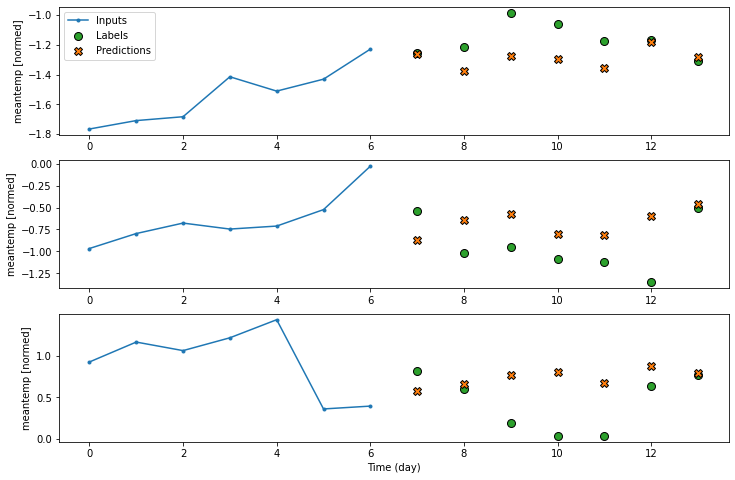

In [143]:
%%time
val_perf = []
test_perf = []
for i in range(1,31):
    w = helpers.WindowGenerator(input_width=i,
                                label_width=HORIZON,
                                shift=HORIZON,
                                train_df=train_df,
                                val_df=val_df,
                                test_df=test_df)
    lstm = tf.keras.models.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(HORIZON*num_features),
        tf.keras.layers.Reshape([HORIZON, num_features])
    ])

    _ = helpers.compile_and_fit(lstm, w, patience=15)

    val_perf.append(lstm.evaluate(w.val))
    test_perf.append(lstm.evaluate(w.test, verbose=0))

    if i == 7:
        w.plot(lstm)

In [148]:
val_mae = [v[1] for v in val_perf]
test_mae = [v[1] for v in test_perf]

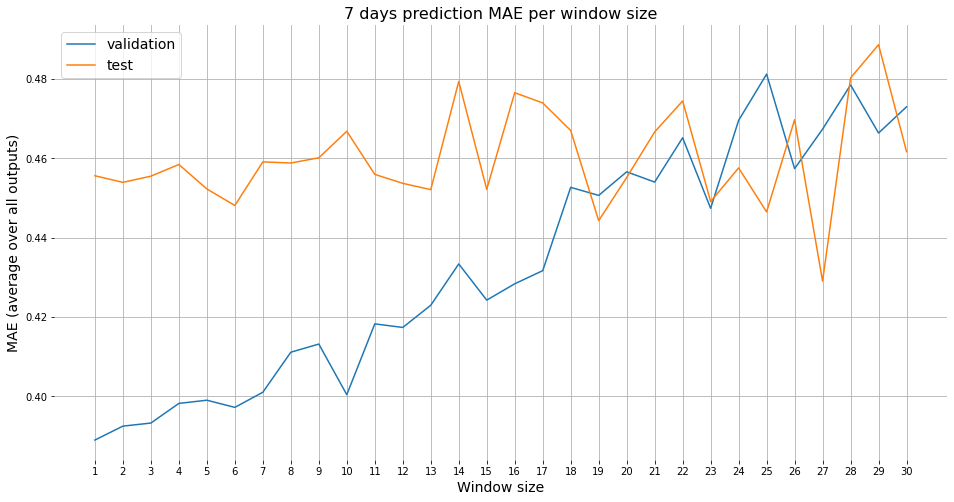

In [154]:
x = np.linspace(1,30,30)
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(x, val_mae, label='validation')
ax.plot(x, test_mae, label='test')
ax.grid(True)
ax.legend(fontsize=14);
ax.set_title('7 days prediction MAE per window size', fontsize=16)
ax.set_frame_on(False)
ax.set_xlabel('Window size', fontsize=14)
ax.set_ylabel('MAE (average over all outputs)', fontsize=14)
ax.set_xticks(x);

fig.savefig('graphs/window_size_benchmark_2.png', facecolor='white')

# Make predictions on the future

In [174]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-window_size:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time 
  for _ in range(into_future):
    
    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-window_size:]
  
  return future_forecast

In [175]:
WINDOW_SIZE = 7

In [186]:
reloaded_model.layers[0].summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 7, 256)           136192    
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 7, 32)             8224      
                                                                 
 dense_10 (Dense)            (None, 7, 4)              132       
                                                                 
Total params: 144,548
Trainable params: 144,548
Non-trainable params: 0
_________________________________________________________________


In [179]:
pred = reloaded_model.predict(tf.expand_dims(df_scaled[-WINDOW_SIZE:], axis=0))
pred = tf.squeeze(pred)

1/1 [==============================] - 0s 19ms/step


In [176]:
future_forecast = make_future_forecast(values=df_scaled,
                                       model=reloaded_model,
                                       into_future=HORIZON,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 18ms/step
Predicting on: 
             meantemp  humidity  wind_speed  meanpressure
date                                                    
2017-04-18  1.195487 -1.950672    0.202216     -0.741145
2017-04-19  1.127392 -2.139680    0.471413     -1.044192
2017-04-20  1.263582 -1.940854   -0.296446     -1.349122
2017-04-21  1.229534 -1.241279    0.014024     -1.179717
2017-04-22  1.045678 -1.151439    0.441475     -0.945937
2017-04-23  1.042273 -1.940854    0.679317     -0.874787
2017-04-24  0.923107 -1.961894    1.166010     -0.601318 -> Prediction: [[ 1.0270027  -2.0042307   0.7488972  -0.5135443 ]
 [ 0.86085045 -1.9719263   0.85886014 -0.6305467 ]
 [ 0.94619465 -1.895204    0.8566992  -0.83665574]
 [ 1.1557562  -1.7540903   0.93466926 -0.82247955]
 [ 1.1914225  -1.7797272   0.86851335 -0.8801067 ]
 [ 1.0270941  -1.8947377   0.8982049  -0.91974676]
 [ 0.9444732  -1.8172492   0.8201002  -0.75839216]]



2022-07-20 10:30:44.307428: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at transpose_op.cc:142 : INVALID_ARGUMENT: transpose expects a vector of size 2. But input(1) is a vector of size 3
2022-07-20 10:30:44.308562: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at transpose_op.cc:142 : INVALID_ARGUMENT: transpose expects a vector of size 2. But input(1) is a vector of size 3


InvalidArgumentError: Graph execution error:

transpose expects a vector of size 2. But input(1) is a vector of size 3
	 [[{{node transpose}}]]
	 [[custom_residual_wrapper/StatefulPartitionedCall/StatefulPartitionedCall/sequential_4/bidirectional_2/backward_lstm_2/PartitionedCall]] [Op:__inference_predict_function_1669480]